In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

# the next two lines will expand the printed tables
# pd.options.display.max_rows= 40000
# pd.options.display.max_columns= 40000

In [2]:
READ_METAFILE= pd.read_excel(r"..\FEDXD_METAFILE.xlsx" ,sheet_name="METAFILE" )
len(READ_METAFILE)
READ_METAFILE


,MOUSEID,SEX,BATCH,FEDFILE,CHOICE_SESSION,FED_PELLET,MODE,DIET
0,FEDXDF1,F,1,FED001_032923_02.CSV,0,MIX,FF,PR
1,FEDXDF1,F,1,FED001_033023_01.CSV,0,MIX,FR,PR
2,FEDXDF1,F,1,FED001_040923_00.CSV,1,CAS20,FR,PR
3,FEDXDF1,F,1,FED002_040923_00.CSV,1,CAS5,FR,PR
4,FEDXDF1,F,1,FED001_041323_00.CSV,2,CAS20,FR,PR
...,...,...,...,...,...,...,...,...
400,FEDXDM20,M,4,FED020_041623_00.CSV,2,SUC,FR,NR
401,FEDXDM20,M,4,FED019_042023_00.CSV,3,CAS5,FR,NR
402,FEDXDM20,M,4,FED020_042023_00.CSV,3,SUC,FR,NR
403,FEDXDM20,M,4,FED007_042523_00.CSV,4,CAS5,CE,NR


In [3]:
## list of questions to ask with data

# Fig 1
# is there a difference in pellets taken on FF between PR and NR
# is there a difference in learning to poke between PR and NR (active vs inactive) on day 1 of FR (choice session 0)
# is there a difference between number of pellets taken in the same session
### also consider male vs female in same analyses

# Fig 2
# In choice session 1 is there a difference between 20% and 5% for PR vs NR


# Fig 3
# In choice session 2 is there a difference between 20% and sucrose
# In choice session 3 is there a difference between 5% and sucrose


# Fig 4
# In choice session 4 (closed economy) is there a difference between 5% and sucrose in breakpoints between PR and NR

# Possible additional
# switches between FEDs, average time before going to the other FED
# circadian differences





In [4]:
DATA_FOLDER = "..\\data"


def tweak_fed(df):
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
#              .set_index("t")
#              .query("Event == 'Pellet'")
             # .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:, ["t", "Event", "FR", "Device_Number", "ipi", "Poke_Time"]]
           )

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_041723_00.CSV"))
df1 = tweak_fed(df)

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED002_041723_00.CSV"))
df2 = tweak_fed(df)

In [5]:
print(df1.head(3))
print(df2.head(3))

                    t   Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:10   Right   1              1  NaN      12.78
1 2023-04-17 11:19:11    Left   1              1  NaN       0.25
2 2023-04-17 11:21:57  Pellet   1              1  NaN        NaN
                    t  Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:20  Right   1              2  NaN      12.59
1 2023-04-17 11:25:38  Right   1              2  NaN       0.00
2 2023-04-17 11:26:38   Left   1              2  NaN       0.25


In [6]:
def clean_fed(df):
    
    return (df
            .iloc[1:]
            .set_index("t")
           )

def sync_feds(df1, df2):
    
    offset = df2.query("Poke_Time > 10").t - df1.query("Poke_Time > 10").t
    offset = pd.Timedelta(offset.iloc[0])
    
    
    df2 = df2.assign(t=df2.t.sub(offset))
#     df1 = clean_fed(df1)
#     df2 = clean_fed(df2)
    
    return df1, df2, offset

df1, df2, offset = sync_feds(df1, df2)

print(df1.head(3))
print(df2.head(3))
offset.total_seconds()

                    t   Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:10   Right   1              1  NaN      12.78
1 2023-04-17 11:19:11    Left   1              1  NaN       0.25
2 2023-04-17 11:21:57  Pellet   1              1  NaN        NaN
                    t  Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:10  Right   1              2  NaN      12.59
1 2023-04-17 11:25:28  Right   1              2  NaN       0.00
2 2023-04-17 11:26:28   Left   1              2  NaN       0.25


10.0

In [7]:
METAFILE = "..\\FEDXD_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE_SE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    MOUSEID,SEX,BATCH,FEDFILE,CHOICE_SESSION,FED_PELLET,MODE,DIET = row
    if (MODE == "FF" or "FR" or "CE") and (DIET in ["NR", "PR"] and FED_PELLET in ["MIX","CAS5","CAS20","SUC"] and CHOICE_SESSION in["ZERO","ONE","TWO","THREE","FOUR"] ):
        key = "_".join([MOUSEID,DIET,FED_PELLET,MODE,CHOICE_SESSION])
        ff_dict[key] = {}
        ff_dict[key]["MOUSEID"] = MOUSEID
        ff_dict[key]["DIET"] = DIET
        ff_dict[key]["SEX"] = SEX
        ff_dict[key]["MODE"] = MODE
        ff_dict[key]["CHOICE_SESSION"] = CHOICE_SESSION
        ff_dict[key]["BATCH"] = int(BATCH)
        ff_dict[key]["FED_PELLET"] = FED_PELLET
        ff_dict[key]["events"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, FEDFILE)))

File is excel file. Making csv metafile first


In [8]:
### This cell goes through all the extracted events and synchronizes the two FEDs together

mice = []
for key in ff_dict.keys():
    mice.append(key.split("_")[0])
    
mice = set(mice)

offsets = []
failed_keys =[]
for mouse in mice:
    for session in ["ONE","TWO","THREE","FOUR"]:
        dfs, keys = [], []
        for key, val in ff_dict.items():
            if (val["MOUSEID"] == mouse) and (val["CHOICE_SESSION"] == session):
                keys.append(key)
                dfs.append(val["events"])
        try:
            df1, df2, offset = sync_feds(dfs[0], dfs[1])
            ff_dict[keys[0]]["events"] = df1
            ff_dict[keys[1]]["events"] = df2
            offsets.append(offset.total_seconds())
        except IndexError:
            print("Cannot sync for keys {}".format(keys))
            failed_keys.append(keys)

offsets = [0 if np.isnan(i) else i for i in offsets]
print(failed_keys)
print(offsets)
        

Cannot sync for keys ['FEDXDF12_NR_CAS20_FR_ONE', 'FEDXDF12_NR_CAS5_FR_ONE']
Cannot sync for keys ['FEDXDF20_NR_CAS20_FR_TWO', 'FEDXDF20_NR_SUC_FR_TWO']
[['FEDXDF12_NR_CAS20_FR_ONE', 'FEDXDF12_NR_CAS5_FR_ONE'], ['FEDXDF20_NR_CAS20_FR_TWO', 'FEDXDF20_NR_SUC_FR_TWO']]
[-3.0, -5.0, -6.0, -8.0, -9.0, -12.0, -15.0, -17.0, 0, -5.0, -6.0, -8.0, -10.0, -13.0, -16.0, -18.0, 10.0, 11.0, 10.0, 9.0, -18.0, -23.0, -28.0, -33.0, 2.0, 2.0, 2.0, 4.0, -16.0, -21.0, -25.0, -30.0, -4.0, -6.0, -7.0, -9.0, -10.0, -13.0, -16.0, -18.0, 12.0, 18.0, 23.0, 27.0, 5.0, 5.0, 6.0, 7.0, 0, 0, 26.0, 30.0, 19.0, 25.0, 30.0, 36.0, -8.0, -11.0, -14.0, -17.0, 5.0, 6.0, 7.0, 8.0, 11.0, 10.0, 9.0, 9.0, 9.0, 10.0, 12.0, 39.0, 4.0, 5.0, 6.0, 8.0, 2.0, 3.0, 3.0, 3.0, -19.0, 9.0, -29.0, 14.0, 18.0, 24.0, 28.0, 7.0, 12.0, 8.0, 20.0, 26.0, 32.0, 38.0, 15.0, 20.0, 25.0, 29.0, 0, 5.0, 5.0, 7.0, 17.0, 23.0, 28.0, 34.0, 0, 3.0, 3.0, 4.0, 0, 5.0, 7.0, 7.0, 9.0, 10.0, 0, 8.0, 4.0, 5.0, 7.0, 8.0, -4.0, -5.0, -7.0, -8.0, 11.0, 10.0, 10.

<Axes: ylabel='Density'>

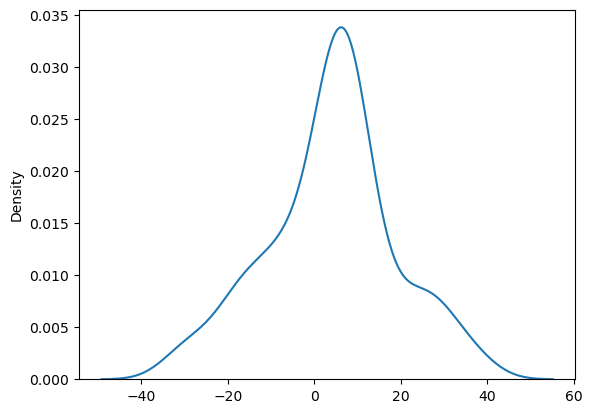

In [9]:
# shows that FEDs are normally only out of sync by 40 seconds or less
# need to inspect nans to work out what is happening there

sns.kdeplot(offsets)

In [10]:
# get total pellets of each kind

def selector(data, mouse, session, pellet_types):
    
    selected_dicts = []
    
    for key, val in data.items():
        if (val["MOUSEID"] == mouse) and (val["CHOICE_SESSION"] == session):
            selected_dicts.append(val)
            
    if len(selected_dicts) != 2:
        print("Incorrect number of fed sessions returned for {}_{} (should be exactly two)".format(mouse, session))
        return
    
    if pellet_types[0] in selected_dicts[0]["FED_PELLET"]:
        fed1 = selected_dicts[0]
    elif pellet_types[0] in selected_dicts[1]["FED_PELLET"]:
        fed1 = selected_dicts[1]
    else:
        print(f"{pellet_types[0]} is not in the selected dictionaries")
        return
    
    if pellet_types[1] in selected_dicts[0]["FED_PELLET"]:
        fed2 = selected_dicts[0]
    elif pellet_types[1] in selected_dicts[1]["FED_PELLET"]:
        fed2 = selected_dicts[1]
    else:
        print(f"{pellet_types[1]} is not in the selected dictionaries")
        return

    return fed1, fed2
    
cas5, suc = selector(ff_dict, "FEDXDF8", "FOUR", ["CAS5", "SUC"])
     

In [11]:
df = suc["events"]
len(df.query("Event == 'Pellet'"))

41

In [12]:
df

,t,Event,FR,Device_Number,ipi,Poke_Time
0,2023-04-22 11:17:32,Right,1,6,NaN,17.38
1,2023-04-22 11:22:38,Left,1,6,NaN,0.11
2,2023-04-22 11:22:45,Pellet,1,6,NaN,NaN
3,2023-04-22 11:22:57,Right,3,6,NaN,0.21
4,2023-04-22 11:37:46,Right,3,6,NaN,0.03
...,...,...,...,...,...,...
1250,2023-04-23 09:43:02,Left,67,6,NaN,0.12
1251,2023-04-23 10:04:20,Left,67,6,NaN,0.03
1252,2023-04-23 10:04:21,Left,67,6,NaN,0.11
1253,2023-04-23 10:10:38,Left,67,6,NaN,0.44


In [ ]:
def get_data(entry):
    
    df = pd.DataFrame()
    
    return (df.
            assign(total_pellets=len(entry["events"].query("Event == 'Pellet'")))
           )

def assemble_dataframe(data):
    
    collection_of_dfs = []
    
    for key, val in data.items():
        collection_of_dfs.append(get_data(val))
        
    return pd.concat(collection_of_dfs)
        


In [13]:
def calc_max_breakpoint(df):

    return df.FR.max()

def calc_mean_breakpoint(df):
    
    return df.FR.mean()

def calc_median_breakpoint(df):
    
    return df.FR.median()
    
calc_mean_breakpoint(suc["events"])

42.549003984063745

In [22]:
def calc_total_pellets(df):
    return len(df.query("Event == 'Pellet'"))
    
    
def calc_max_breakpoint(df):
    return
    
    
total_pellets_NR_suc, total_pellets_NR_cas5, total_pellets_PR_suc, total_pellets_PR_cas5 = [], [], [], []

mouse_diets = {}
for mouse in mice:
    for key, val in ff_dict.items():
        if mouse not in mouse_diets.keys():         
            if mouse in key:
                mouse_diets[mouse] = val["DIET"]

for idx, mouse in enumerate(mice):
    cas5, suc = selector(ff_dict, mouse, "FOUR", ["CAS5", "SUC"])
    
    if mouse_diets[mouse] == "NR":
        total_pellets_NR_cas5.append(calc_max_breakpoint(cas5["events"]))
        total_pellets_NR_suc.append(calc_max_breakpoint(suc["events"]))
    elif mouse_diets[mouse] == "PR":
        total_pellets_PR_cas5.append(calc_max_breakpoint(cas5["events"]))
        total_pellets_PR_suc.append(calc_max_breakpoint(suc["events"]))
    else:
        print("Incorrect diet option")

len(mice)

40

In [23]:
total_pellets_NR.shape

(20, 2)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

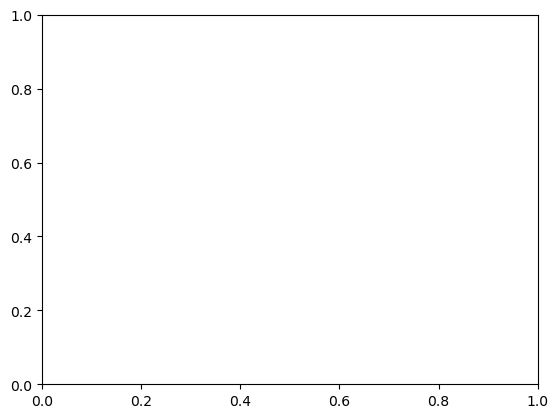

In [24]:
plt.boxplot((total_pellets_NR_suc, total_pellets_NR_cas5, total_pellets_PR_suc, total_pellets_PR_cas5));

In [ ]:
def get_total_pellets(df):
    
    pellets = df.query("Event == 'Pellet'")
    
    return len(pellets)
    
    
    

In [ ]:
### Need to pick a comparison, e.g. FR_ONE

cas5, cas20 = [], []

for key, val in ff_dict.items():
    if "FR_ONE" in key:
        if val["FED_PELLET"] == "CAS5":
            cas5.append(get_total_pellets(val["events"]))
        elif val["FED_PELLET"] == "CAS20":
            cas20.append(get_total_pellets(val["events"]))
        else:
            print("check {}".format(key))
            
assert len(cas5) == len(cas20)

tp.barscatter([cas5, cas20], paired=True);

In [ ]:
### assemble dataframe for session 1 - FR cas5 vs cas20

SESSION = "ONE"
CHOICE1 = "CAS5"
CHOICE2 = "CAS20"

dfs = []
for mouse in mice:
    for key, val in ff_dict.items():
        if (mouse in key) and ("ONE" in key):
            diet = val["DIET"]
            sex = val["SEX"]
            choice = val["FED_PELLET"]
            total_pellets = get_total_pellets(val["events"])
            
            df_temp = pd.DataFrame(data={"mouse": mouse,
                                         "diet": diet,
                                         "sex": sex,
                                         "fed_pellet": choice,
                                         "total_pellets": total_pellets
                                         }, index=[key])
            
            dfs = dfs.append(df_temp)
            
df = pd.concat(dfs)

In [ ]:
df_temp

In [ ]:
pd.DataFrame(data=mice, columns=["mouseid"])

In [ ]:
CHOICE1=ff_dict["FEDXDF1_PR_CAS20_FR_ONE"]["events"].head(20)
CHOICE2=ff_dict["FEDXDF1_PR_CAS5_FR_ONE"]["events"].head(20)

In [ ]:
print(CHOICE2)

In [ ]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [ ]:
mice

In [ ]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["CHOICE_SESSION"]= val["CHOICE_SESSION"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       